In [2]:
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from einops import rearrange
from PIL import Image
plt.rcParams['figure.figsize'] = [50, 10]


In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
generated_batch = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/generated_batch.pt", map_location=torch.device("cpu"))
logit_arr = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/logit_arr.pt", map_location=torch.device("cpu"))
weight_arr = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/weight_arr.pt", map_location=torch.device("cpu"))
target = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/target.pt", map_location=torch.device("cpu"))
cond = torch.load("/scratch/work/spieglb1/palette-view-synthesis/logs/2023-12-20T17-50-09-multi-view-composable/cond.pt", map_location=torch.device("cpu"))

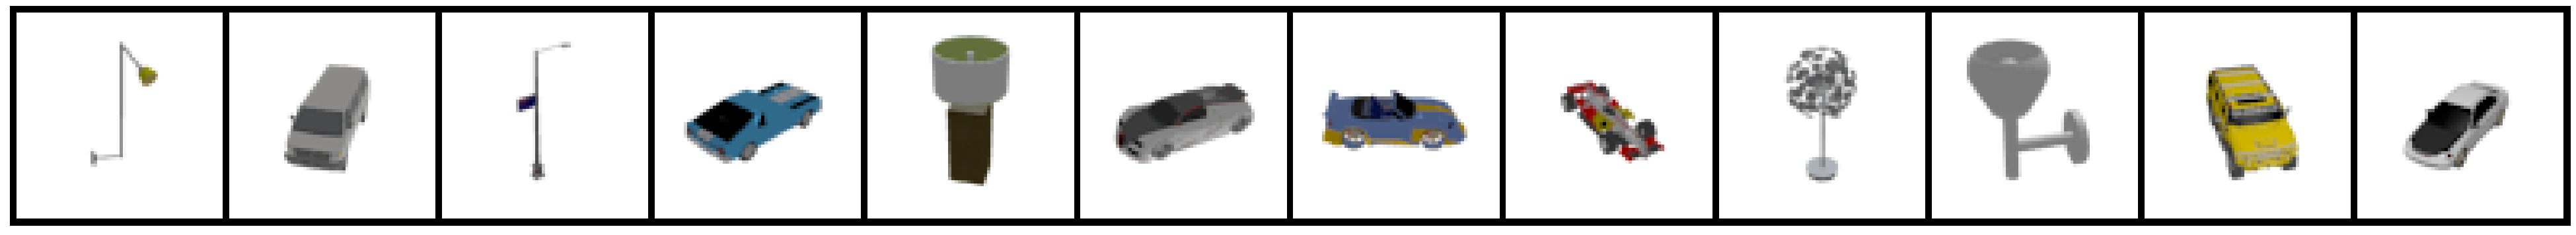

In [5]:
target_grid = make_grid(target, nrow=12)
show(target_grid)

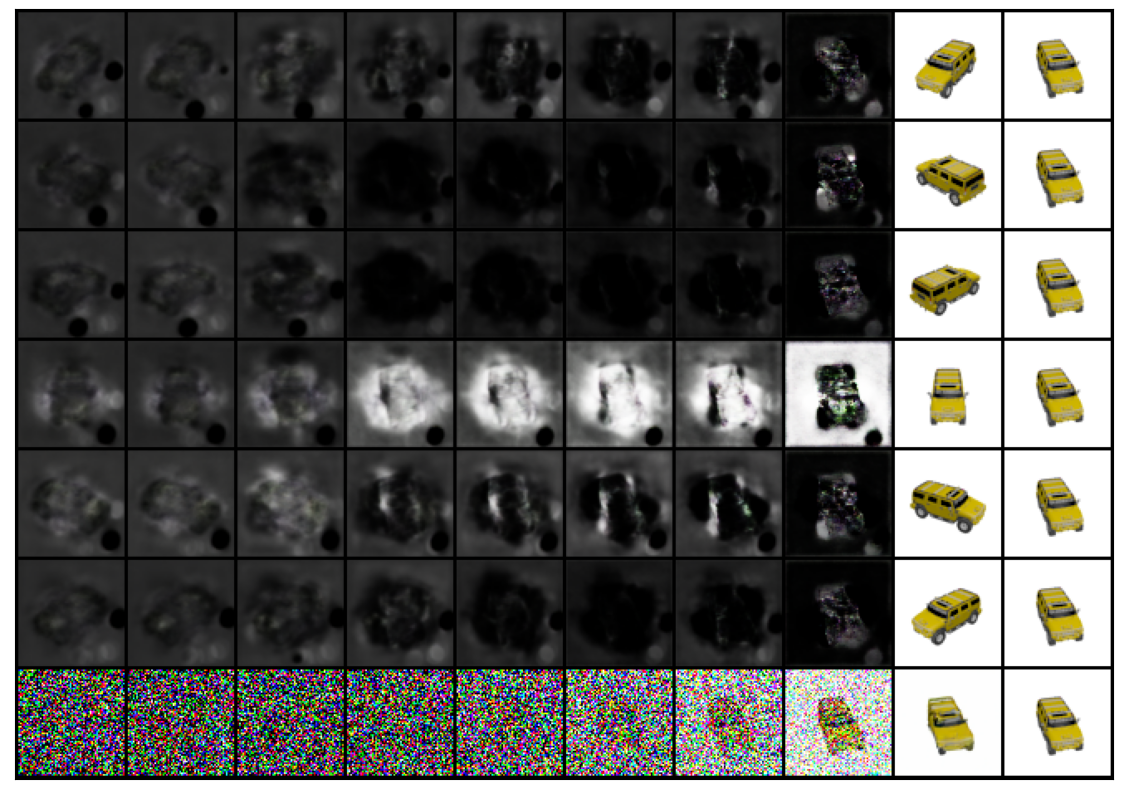

In [80]:
i = 10
target_grid = torch.cat([target[i, ...][None, ...],] * (cond.shape[1] + 1))[None, ...]
view_weights = torch.cat((weight_arr[i, ...], cond[i, :, :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0])
show(view_weights)